In [1]:
from myclasses.sql_executor import SQLExecutor
import pandas as pd

if __name__ == "__main__":
    # Create an instance of SQLExecutor
    sql_executor = SQLExecutor()

    # Example SQL query
    query = """
        SELECT 
            (net_income / ((total_assets + total_liabilities) * num_beds)) as roe,
            year,
            ownership,
            acct_payable,
            acct_rec,
            total_liabilities,
            tot_fund_balance,
            current_ratio,
            quick_ratio,
            pct_fixed_assets,
            pct_other_assets,
            (tot_days / tot_bed_days_avail) as fill_rate,
            cash,
            chow_last_12mos,
            region,
            state,
            state_lean,
            county_ssa,
            zip,
            tot_discharge_tot,
            def_score,
            fine_tot,
            fine_cnt,
            resfamcouncil,
            sprinkler_status,
            overall_rating,
            quality_rating,
            staffing_rating,
            rn_staffing_rating,
            aidhrd,
            vochrd,
            rnhrd,
            totlichrd,
            tothrd,
            pthrd,
            weighted_all_cycles_score,
            certification,
            snf_avg_stay_len_title_tot,
            pop_over_70,
            over_70_pct,
            has_outpatient,
            bedcert,
            fac_type,
            staff_style,
            totlichrd_to_tot
            
            
        FROM Master
        WHERE 
            roa > -1 
            AND roa < 1 
            AND total_assets > 0
            AND total_liabilities > 0 
            AND operating_income < 15000000 
            AND operating_income > -15000000
            AND year <> 2021
        ORDER BY prov_id; 
        """

    # Execute the query and get the result as a DataFrame
    df = sql_executor.execute_query(query)

In [2]:

def bin_income(data):
    if data >= 0:
        return '1_profit'
    else:
        return '0_loss'
    
df['roe'] = df['roe'].apply(bin_income)

# Make y label
y = df['roe']
df = df.drop(columns=['roe'])

In [3]:
from sklearn.preprocessing import MinMaxScaler

# Initialize the scaler
scaler = MinMaxScaler()

# Select numerical columns
quant_cols = df.select_dtypes(include=['number']).columns

# Apply scaling only to the selected numerical columns
df[quant_cols] = scaler.fit_transform(df[quant_cols])

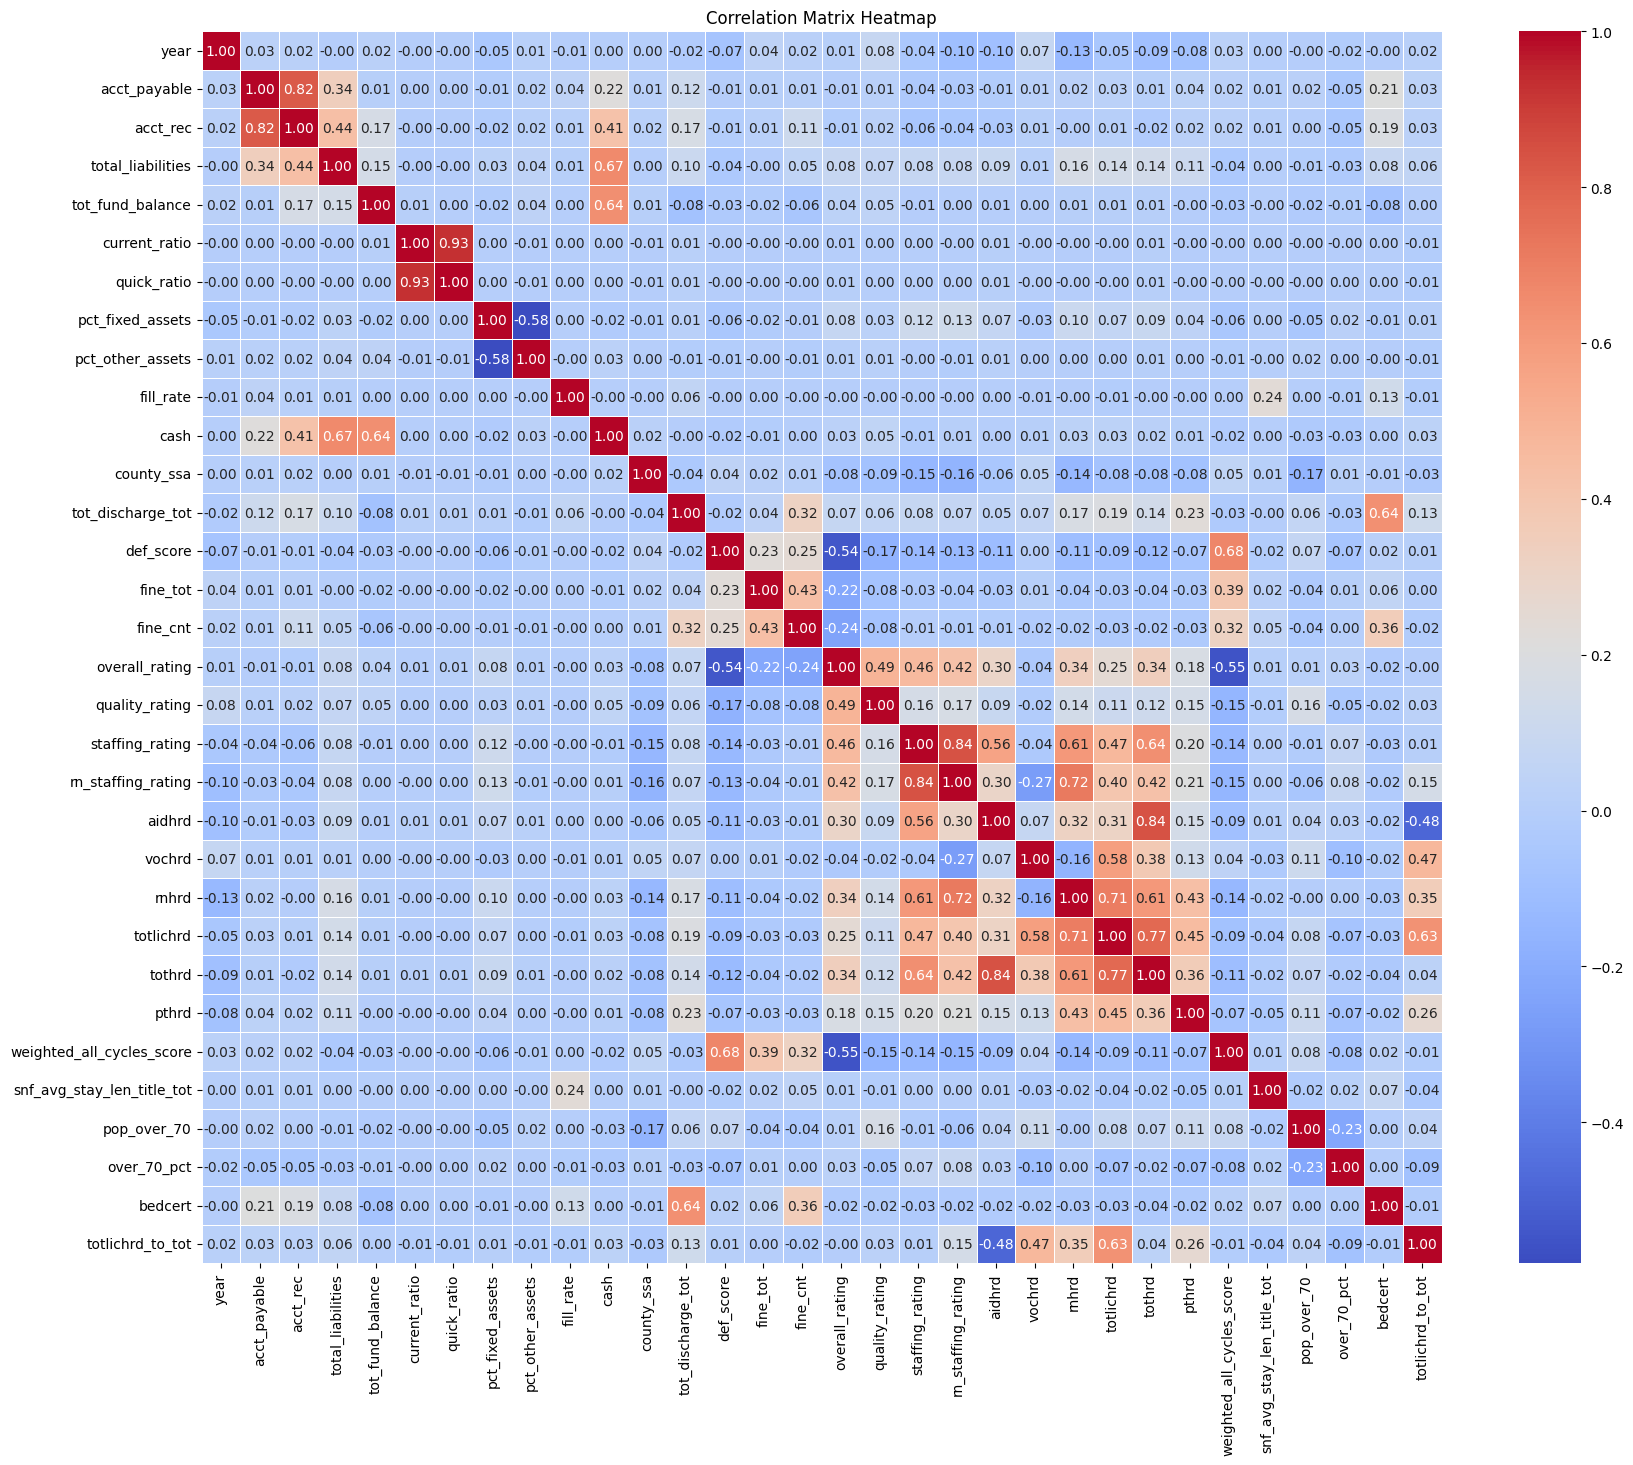

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

# Concatenate y and X along the columns axis
data = df.select_dtypes(include=['number'])

# Remove 0 columns
non_zero_columns = data.columns[(data != 0).any()]
data = data[non_zero_columns]

# Compute the correlation matrix
correlation_matrix = data.corr()

# Plot heatmap
plt.figure(figsize=(20, 16))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

In [5]:
from sklearn.model_selection import train_test_split

# Select columns where data type is text (object)
text_columns = df.select_dtypes(include=['object']).columns

# Create dummy variables for text columns
df_encoded = pd.get_dummies(df, columns=text_columns)

# Convert all columns to numeric type
df_encoded = df_encoded.apply(pd.to_numeric, errors='coerce')

# Set X
X = df_encoded

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=84)


In [6]:
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder

# Convert class labels to integers using LabelEncoder
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

# Define XGBoost classifier and set hyperparameters for multiclass classification
xgb_model = xgb.XGBClassifier(
    booster='gbtree',
    seed=1001,
    n_estimators=10000,          # Iterations of the model
    learning_rate=0.0085,         # Speed at which the learners optimize
    max_depth=4,                # Depth of the weak learners
    min_child_weight=1, 
    device = 'cuda',    
    subsample=0.85,
    colsample_bytree=0.95,
    random_state=42,
    eval_metric='merror',         # Multiclass logloss for evaluation
    objective='multi:softprob',  # Use softmax for multiclass classification
    num_class=4,                # Number of classes in your dataset
    gamma=0.4,                 # Increasing this value will make model more conservative
    reg_alpha=0.49,             # Increasing this value will make model more conservative
    reg_lambda=0.5,            # Increasing this value will make model more conservative
    early_stopping_rounds=2500
)

# Train the model with progress printout
xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],  # Evaluation set for tracking progress
    verbose=500                                       # Print progress
)

[0]	validation_0-merror:0.28576	validation_1-merror:0.29257
[500]	validation_0-merror:0.26833	validation_1-merror:0.28035
[1000]	validation_0-merror:0.25666	validation_1-merror:0.27464
[1500]	validation_0-merror:0.24703	validation_1-merror:0.27075
[2000]	validation_0-merror:0.23798	validation_1-merror:0.26782
[2500]	validation_0-merror:0.23037	validation_1-merror:0.26504
[3000]	validation_0-merror:0.22354	validation_1-merror:0.26305
[3500]	validation_0-merror:0.21733	validation_1-merror:0.26145
[4000]	validation_0-merror:0.21162	validation_1-merror:0.26048
[4500]	validation_0-merror:0.20635	validation_1-merror:0.26016
[5000]	validation_0-merror:0.20069	validation_1-merror:0.25957
[5500]	validation_0-merror:0.19542	validation_1-merror:0.25915
[6000]	validation_0-merror:0.19085	validation_1-merror:0.25835
[6500]	validation_0-merror:0.18556	validation_1-merror:0.25790
[7000]	validation_0-merror:0.18073	validation_1-merror:0.25710
[7500]	validation_0-merror:0.17639	validation_1-merror:0.25

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.95, device='cuda', early_stopping_rounds=2500,
              enable_categorical=False, eval_metric='merror',
              feature_types=None, gamma=0.4, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.0085, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=1, missing=nan,
              monotone_constraints=None, multi_strategy=None,
              n_estimators=10000, n_jobs=None, num_class=4,
              num_parallel_tree=None, ...)

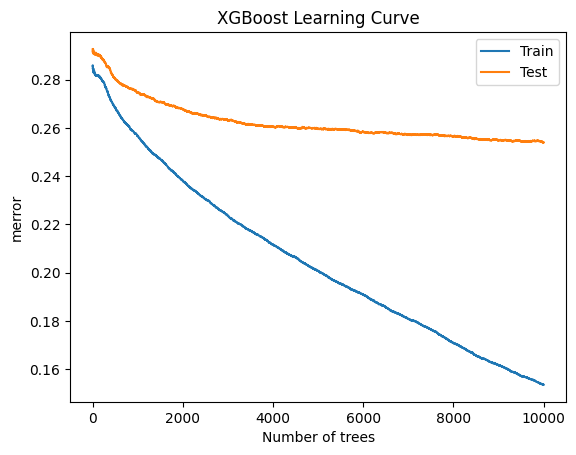

In [7]:
# Get the evaluation results
results = xgb_model.evals_result()
epochs = len(results['validation_0']['merror'])
x_axis = range(0, epochs)

# Plot the learning curve with multi-logloss
plt.plot(x_axis, results['validation_0']['merror'], label='Train')
plt.plot(x_axis, results['validation_1']['merror'], label='Test')
plt.legend()
plt.xlabel('Number of trees')
plt.ylabel('merror')
plt.title('XGBoost Learning Curve')
plt.show()

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np


# Make predictions on the test set
y_pred = xgb_model.predict(X_test)
y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]  

conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plotting ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


ValueError: Classification metrics can't handle a mix of binary and multilabel-indicator targets

In [13]:
from sklearn.metrics import classification_report

# Generate classification report
class_report = classification_report(y_test, y_pred)

# Print the classification report
print("Classification Report:")
print("----------------------")
print(class_report)

ValueError: Classification metrics can't handle a mix of binary and multilabel-indicator targets

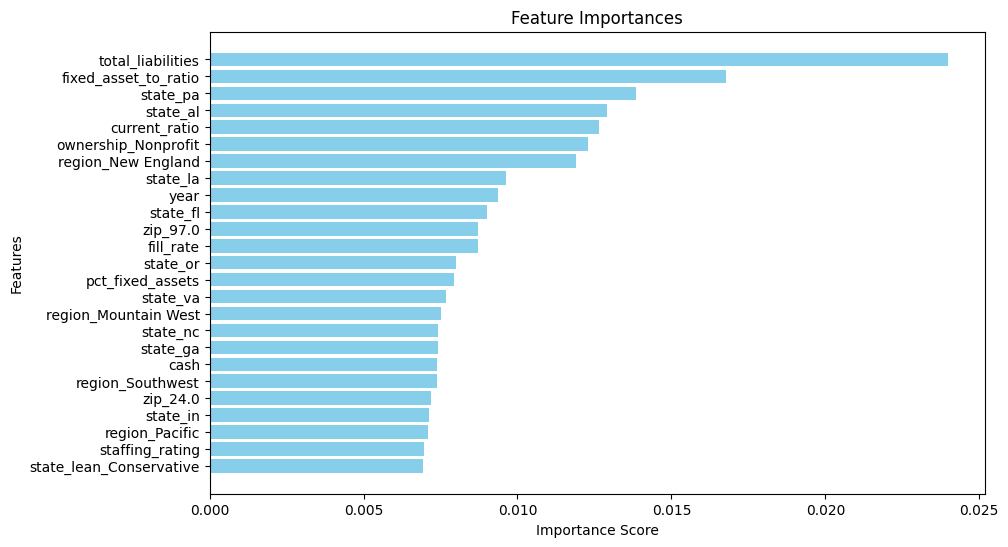

In [ ]:
# Assuming xgb_model is your trained XGBoost model
feature_importance = xgb_model.feature_importances_

# Create a dictionary mapping feature names to their importance scores
feature_importance_dict = dict(zip(X_train.columns, feature_importance))

# Sort feature importance dictionary by importance score
sorted_features = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# Extract feature names and importance scores
features = [f[0] for f in sorted_features[:25]]
importance_scores = [f[1] for f in sorted_features[:25]]

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(features, importance_scores, color='skyblue')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.title('Feature Importances')
plt.gca().invert_yaxis()  # Invert y-axis to display highest importance at the top
plt.show()